# Чётенькое такси

**Описание проекта**

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Нужно построить модель для такого предсказания.

Значение метрики RMSE на тестовой выборке должно быть не больше 48.

## Загрузка и подготовка данных

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [9]:
# константы
RANDOM_STATE = 42

In [10]:
# загружаем и сохраняем датасет
try:
    df = pd.read_csv('taxi.csv', index_col = [0], parse_dates = [0])

except:
    df = pd.read_csv('/datasets/taxi.csv', index_col = [0], parse_dates = [0])

In [11]:
# сортируем по индексам
df.sort_index(inplace = True)

In [12]:
# проверям идут ли индексы по порядку
print(df.index.is_monotonic_increasing)

True


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [14]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [15]:
df.index.min()

Timestamp('2018-03-01 00:00:00')

In [16]:
df.index.max()

Timestamp('2018-08-31 23:50:00')

In [17]:
# ресемплирование по одному часу
df = df.resample('1H').sum()

C:\Users\кц\AppData\Local\Temp\ipykernel_6084\1234156008.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample('1H').sum()


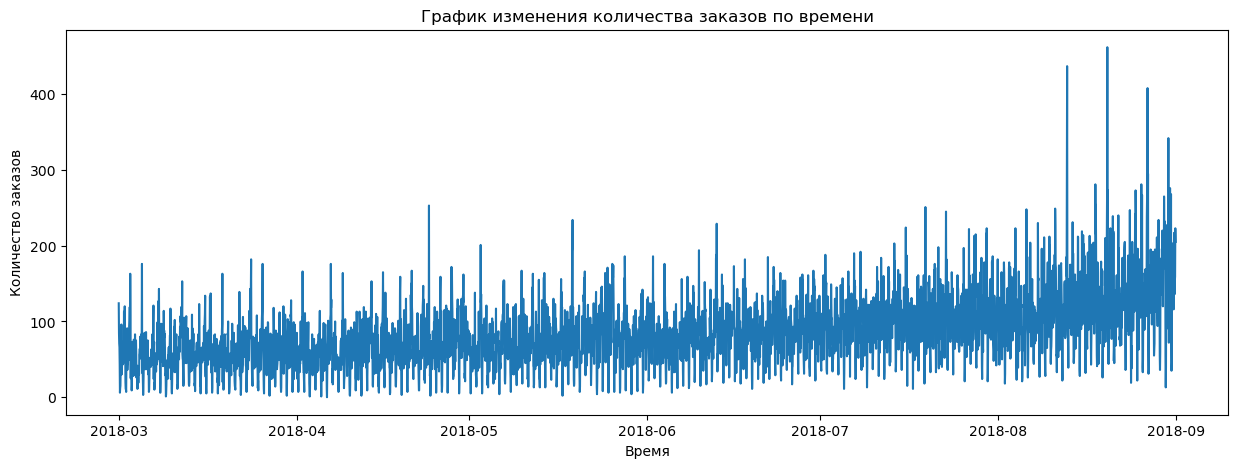

In [18]:
plt.figure(figsize = (15,5))
sns.lineplot(data=df, x=df.index, y='num_orders')\
.set(title='График изменения количества заказов по времени',
    xlabel='Время',
    ylabel='Количество заказов');
plt.show()

Загрузили данные, 
пропуски не обнаружены, 
индексы в формате datetime в идут в порядке от '2018-03-01 00:00:00' до '2018-08-31 23:00:00', 
По условию заказчика провели ресемплирование данных по одному часу, в общем по графику видно увеличения кол-во заказов такси примерно начина с конца весны и до конца лета.

### Аналзиз временного ряда

Проведем ряд исследований с применением графиком.

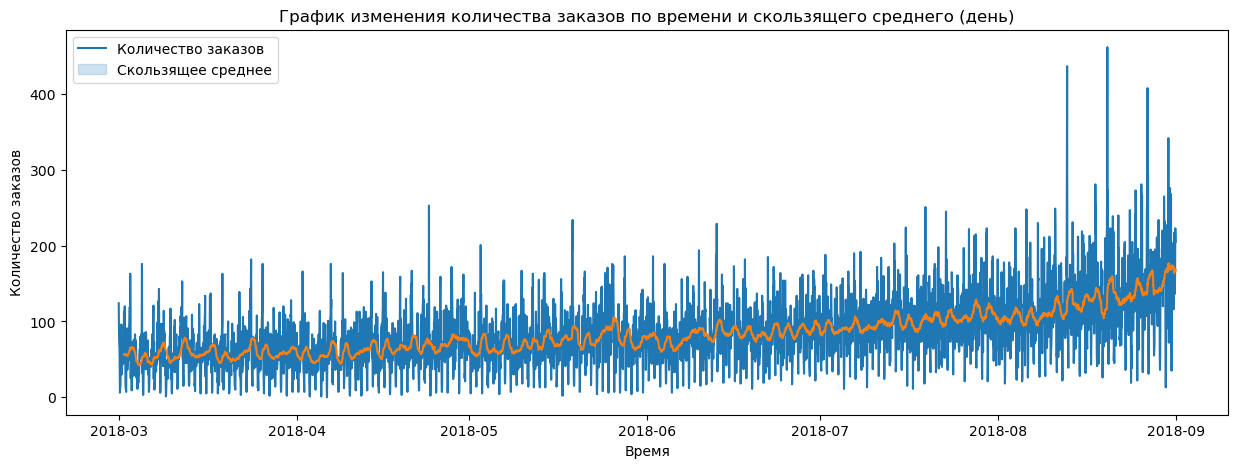

In [22]:
#применим скользящее среднее с размером окна 1 день(24) для сглаживания временного ряда
plt.figure(figsize = (15,5))
sns.lineplot(data=df, x=df.index, y='num_orders')\
.set(title='График изменения количества заказов по времени и скользящего среднего (день)',
    xlabel='Время',
    ylabel='Количество заказов')
sns.lineplot(data=df.rolling(24).mean(), x=df.index, y='num_orders')

plt.legend(labels=['Количество заказов', 'Скользящее среднее'])
plt.show()

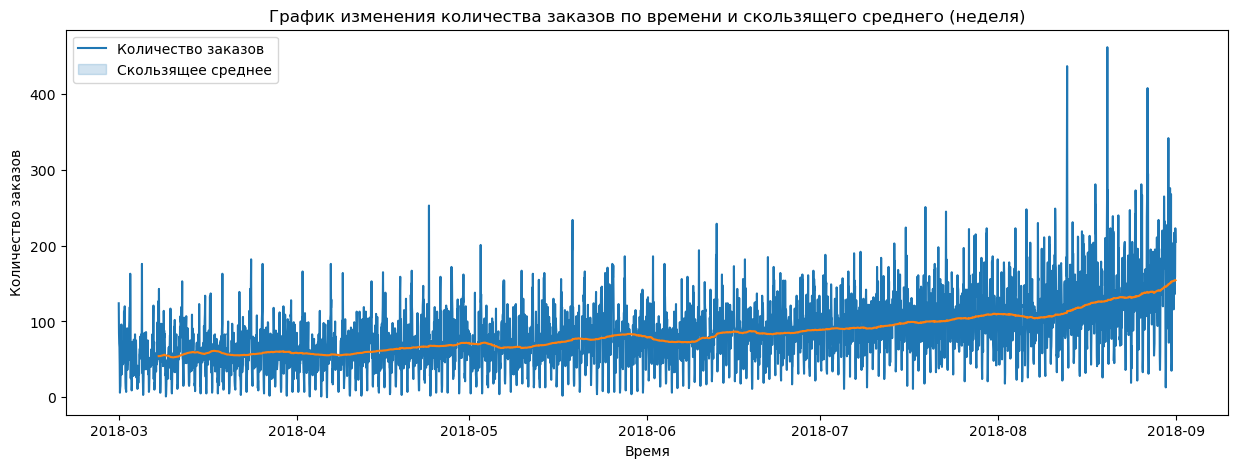

In [23]:
#применим скользящее среднее с размером окна 1 неделя для сглаживания временного ряда
plt.figure(figsize = (15,5))
sns.lineplot(data=df, x=df.index, y='num_orders')\
.set(title='График изменения количества заказов по времени и скользящего среднего (неделя)',
    xlabel='Время',
    ylabel='Количество заказов')
sns.lineplot(data=df.rolling(24*7).mean(), x=df.index, y='num_orders');
plt.legend(labels=['Количество заказов', 'Скользящее среднее']);

При скользящем среднем с размером в 1 неделю, четко видно, что кол-во заказов растет от месяца к месяцу.

Посмотрим на тренд и сезонность.

In [25]:
# создадим переменную для тренда, сезонности и шума
decomposed = seasonal_decompose(df)

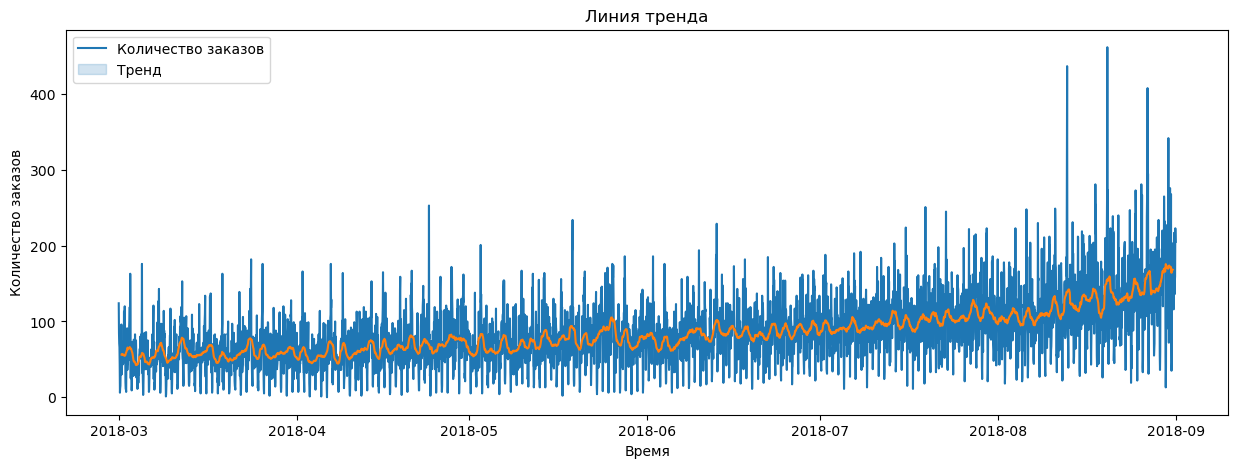

In [26]:
# посмотрим на линию тренда
plt.figure(figsize = (15,5))
sns.lineplot(data=df, x=df.index, y='num_orders')\
.set(title='Линия тренда',
    xlabel='Время',
    ylabel='Количество заказов')
sns.lineplot(data=decomposed.trend)
plt.legend(labels=['Количество заказов', 'Тренд'])
plt.show()

Увеличения кол-во заказов с весны до лета. Скорей всего это связано с тем, что люди возвращаются с отпуска, с путешествия, либо какие-то другие причины.

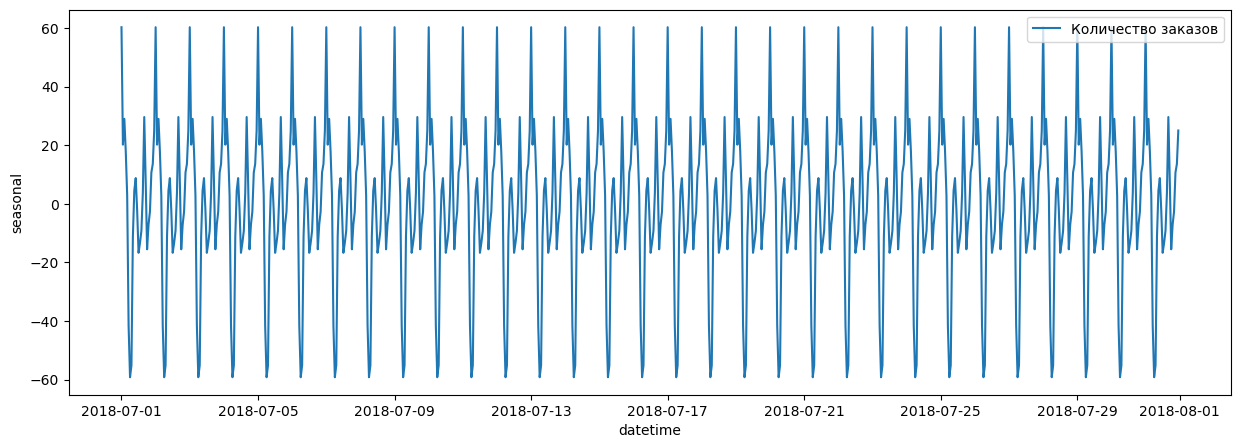

In [28]:
# посмотрим на сезонность за месяц
plt.figure(figsize = (15,5))
sns.lineplot(data=decomposed.seasonal['2018-07-01':'2018-07-31'])
plt.legend(['Количество заказов']);

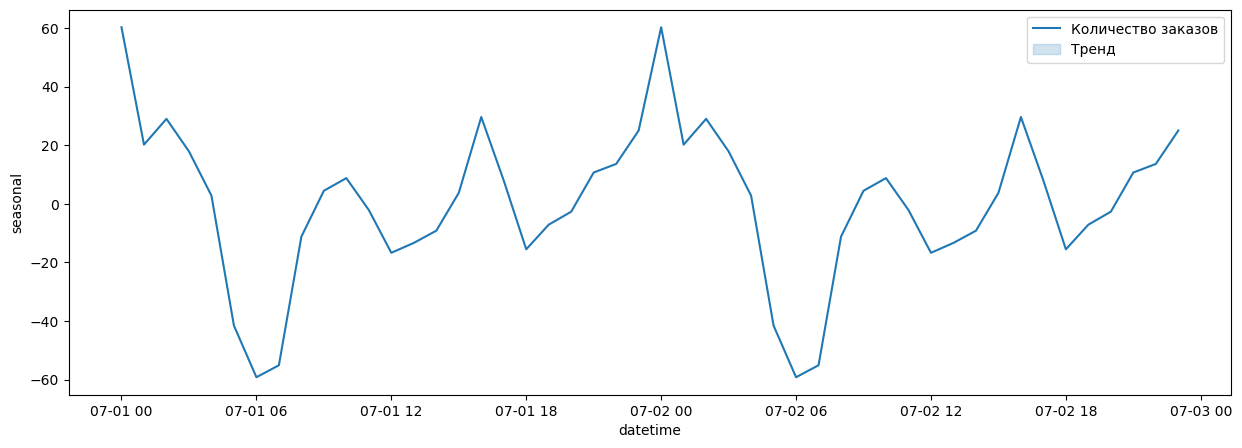

In [29]:
# посмотрим на сезонность
plt.figure(figsize = (15,5))
sns.lineplot(data=decomposed.seasonal['2018-07-01':'2018-07-02'])
plt.legend(labels=['Количество заказов', 'Тренд']);

С 12 часов ночи до 6 утра кол-во заказов падает, затем в общем можно сказать что кол-во заказоав увеличивается целый день до 00:00, но наблюдаются снижения в определенный переиод вермени( ближе к обеду заказы падают, затем после него рост приммерно до 16 и опять спад до 18). С 18 часов до 00 заказы растут и достигают максимума.

В принципе логика прослеживается, ночью в основном все спят, утром вылетают, к обеду хотят кушать, после 18 работа и важные дела заканичивается, можно улетать...,думаю это ещё связано с особенностью расписания рейсов на самолет.

Посмторим на стационарость ряда.

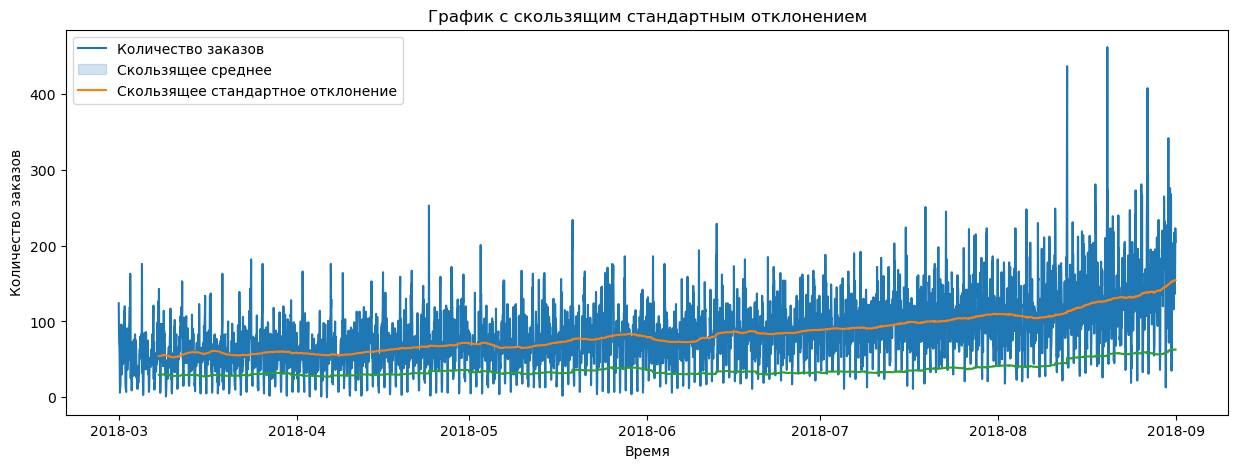

In [31]:
#применим скользящее с стандартным отклонением
plt.figure(figsize = (15,5))
sns.lineplot(data=df, x=df.index, y='num_orders')\
.set(title='График с скользящим стандартным отклонением',
    xlabel='Время',
    ylabel='Количество заказов')
sns.lineplot(data=df.rolling(24*7).mean(), x=df.index, y='num_orders')
sns.lineplot(data=df.rolling(24*7).std(), x=df.index, y='num_orders')

plt.legend(labels=['Количество заказов', 'Скользящее среднее', 'Скользящее стандартное отклонение']);

Попробуем сделать ряд более стационарным.

In [33]:
# рассчитаем разность временного ряда
df_difference = df - df.shift()
df_difference['mean'] = df_difference['num_orders'].rolling(7*24).mean()
df_difference['std'] = df_difference['num_orders'].rolling(7*24).std()

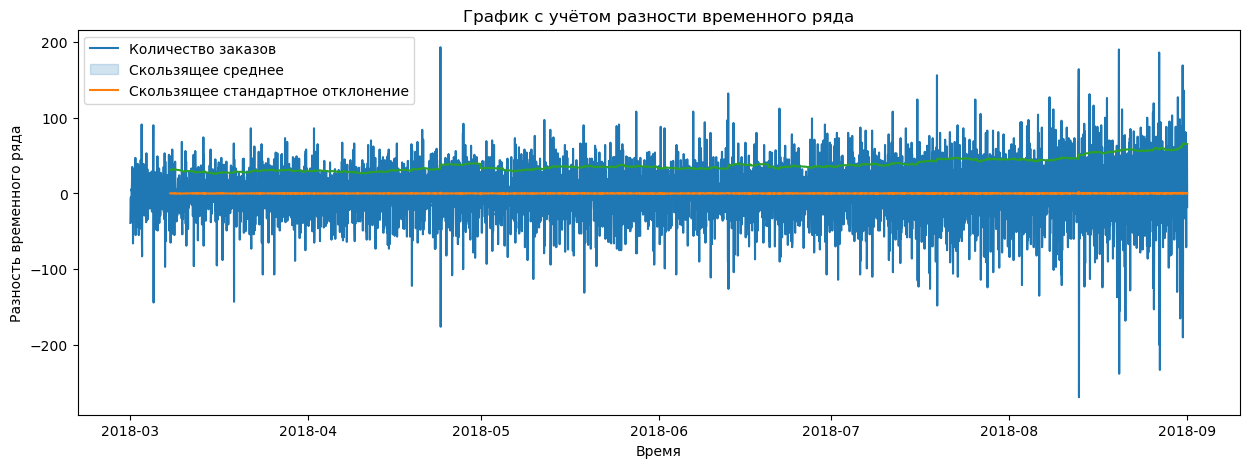

In [34]:
#применим скользящее среднее стандартным отклонением с учётом разности временного ряда
plt.figure(figsize = (15,5))
sns.lineplot(data=df_difference, x=df_difference.index, y='num_orders').\
    set(title='График с учётом разности временного ряда',
         xlabel='Время',
         ylabel='Разность временного ряда')
sns.lineplot(data=df_difference, x=df_difference.index, y='mean')
sns.lineplot(data=df_difference, x=df_difference.index, y='std')
plt.legend(labels=['Количество заказов', 'Скользящее среднее', 'Скользящее стандартное отклонение'])
plt.show()

Разность временного ряда сделала свое дело, теперь ряд больше походит на стационарный.

### Добавление признаков и создание выборок

Создандим новые признаки для обучения моделей и разделим данные на выборки. Размер тествой выборки сделаем 10% от исходного датасета.

In [38]:
# созданим ф-ю для создания признаков и выборок
def prepareData(data, max_lag, rolling_mean_size, test_size):

    # добавляем лаги исходного ряда в качестве признаков
    for i in range(1, max_lag + 1):
        data['lag_{}'.format(i)] = data.num_orders.shift(i)

    
    data['hour'] = data.index.hour
    data['weekday'] = data.index.weekday

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

    data = data.dropna()

    train, test = train_test_split(data, shuffle=False, test_size=test_size)

    X_train = train.drop(columns = 'num_orders')
    y_train = train['num_orders']
    X_test = test.drop(columns = 'num_orders')
    y_test = test['num_orders']

    return X_train, X_test, y_train, y_test


Гиперпараметры max_lag, rolling_mean_size очень важны.  Возможно это самые важные гиперпараметры в проекте, больше всего влияющие на результат.
    
Выбирая значения для размера окна и количества отстающих значений важно использовать известную нам информацию о сезонности. А сезонность у нас есть суточная и недельная. Поэтому рекомендую взять их кратными суткам, а лучше равным неделе.
    
 - Скользящее среднее является олицетворением тренда, и если взять его равным суткам, то оно становится достаточно гладким (из него уходитят колебания, вызванные суточной сезонностью), а если взять равное неделе - то еще ровнее. Это хорошо видно пографикам со скользящим средним, если посмотрить за сутки и неделю.
 
 - На использовании отстающих значений и авторегрессии временного ряда основано много методов прогнозироания временных рядов (например ARIMA). И здесь тоже работает принцип - чем больше признаков - тем выше качество. Но разумным компромисом является использование достаточного количества признаков, такого, где автокореляция является значимой. И такими точками как раз служат сутки и неделя. 

Попробуем исползьзовать гиперпараметры max_lag, rolling_mean_size одинаковыми и  равными 24 (сутки)  или 168 (неделя), лучше оба одинаковые. Использование 168 отстающих значений может сильно усложнить обучение модели, но метрики получаются значительно лучше.

In [40]:
# вызовим ф-ю для с произвольными аргументами и сохраним выборки 
X_train, X_test, y_train, y_test = prepareData(df, 168, 168, 0.1)

C:\Users\кц\AppData\Local\Temp\ipykernel_6084\3883368872.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['lag_{}'.format(i)] = data.num_orders.shift(i)
C:\Users\кц\AppData\Local\Temp\ipykernel_6084\3883368872.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['lag_{}'.format(i)] = data.num_orders.shift(i)
C:\Users\кц\AppData\Local\Temp\ipykernel_6084\3883368872.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

## Обучение моделей

Обученим несколько моделей, сравним их результаты, выберем лучшую по метрике RMSE. 

Значение метрики RMSE на тестовой выборке должно быть не больше 48.

In [43]:
# созданим ф-ю для обучения моделей
def model_train(model, param_grid, X_train, y_train):
    
    # Создаем объект TimeSeriesSplit для перекрестной проверки временных рядов
    tscv = TimeSeriesSplit(n_splits=5)

    # подбираем наилучшие гиперпараметры модели
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)

    grid_search.fit(X_train, y_train)

    return  grid_search

### LinearRegression

In [45]:
#числовые признаки
num_columns = list(df.drop(columns = ['hour', 'weekday', 'num_orders']).columns)
#категориальные признаки
ohe_columns = ['hour', 'weekday']

# кодирование категориальных признаков методом OneHotEncoder
ohe_pipe = Pipeline([('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))])

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
        [
         ('ohe', ohe_pipe, ohe_columns),
         ('num', StandardScaler(), num_columns)
        ], 
        remainder='passthrough'
    )
# финайльный пайплайн для
pipe_lr = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])


In [46]:
%%time
lr_model = model_train(pipe_lr, {}, X_train, y_train)

CPU times: total: 531 ms
Wall time: 8.66 s


In [47]:
# среднее время обучения в секундах
fit_time_lr = lr_model.cv_results_['mean_fit_time'][lr_model.best_index_]
print(fit_time_lr)

0.3038145065307617


In [48]:
# среднее время оценки в секундах
score_time_lr = lr_model.cv_results_['mean_score_time'][lr_model.best_index_]
print(score_time_lr)

0.047002983093261716


In [49]:
# RMSE при кросс-валидации
rmse_lr = (lr_model.best_score_)*(-1)
print(rmse_lr)

23.287290894853847


### XGBRegressor

In [51]:
params_xgbr = {
    "objective": ['reg:squarederror'],
    "n_estimators":[5, 10, 50, 100],
    "max_depth": [4, 6],
    "learning_rate": [0.01, 0.05, 0.1]
}

In [52]:
%%time
xgbr_model = model_train(XGBRegressor(random_state=RANDOM_STATE), params_xgbr, X_train, y_train)

CPU times: total: 10.2 s
Wall time: 1min 33s


In [53]:
# среднее время обучения в секундах
fit_time_xgbr = xgbr_model.cv_results_['mean_fit_time'][xgbr_model.best_index_]
print(fit_time_xgbr)

1.6245220184326172


In [54]:
# среднее время оценки в секундах
score_time_xgbr = xgbr_model.cv_results_['mean_score_time'][xgbr_model.best_index_]
print(score_time_xgbr)

0.040804052352905275


In [55]:
# RMSE при кросс-валидации
rmse_xgbr = (xgbr_model.best_score_)*(-1)
print(rmse_xgbr)

23.023162841796875


### CatBoostRegressor

In [57]:
# Гиперпараметры для модели CatBoostRegressor()
catboost_params = {
    'iterations': [20, 50],
    'depth': [4, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5]
}

In [58]:
%%time
catboost_model = model_train(CatBoostRegressor(loss_function='RMSE', verbose=50, random_state=RANDOM_STATE), catboost_params, X_train, y_train)

0:	learn: 36.8395913	total: 165ms	remaining: 8.1s
49:	learn: 20.6443686	total: 1.1s	remaining: 0us
CPU times: total: 13.9 s
Wall time: 3min 38s


In [59]:
# среднее время обучения в секундах
fit_time_ctbr = catboost_model.cv_results_['mean_fit_time'][catboost_model.best_index_]
print(fit_time_ctbr)

3.1396366596221923


In [60]:
# среднее время оценки в секундах
score_time_ctbr = catboost_model.cv_results_['mean_score_time'][catboost_model.best_index_]
print(score_time_ctbr)

0.037403535842895505


In [61]:
# RMSE при кросс-валидации
rmse_ctbr = (catboost_model.best_score_)*(-1)
print(rmse_ctbr)

23.077044765565347


### LGBMRegressor

In [63]:
# Гиперпараметры для модели LGBMRegressor()
lgbm_params = {
    'num_leaves': [31, 50, 70],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [10, 20]
}

In [64]:
%%time
# обучаем модель LGBMRegressor()
lgbm_model = model_train(LGBMRegressor(random_state=RANDOM_STATE, verbose=0), lgbm_params, X_train, y_train)

CPU times: total: 7.33 s
Wall time: 31.1 s


In [65]:
# среднее время обучения в секундах
fit_time_lgbm = lgbm_model.cv_results_['mean_fit_time'][lgbm_model.best_index_]
print(fit_time_lgbm)

0.8922666072845459


In [66]:
# среднее время оценки в секундах
score_time_lgbm = lgbm_model.cv_results_['mean_score_time'][lgbm_model.best_index_]
print(score_time_lgbm)

0.019802141189575195


In [67]:
# RMSE при кросс-валидации
rmse_lgbm = (lgbm_model.best_score_)*(-1)
print(rmse_lgbm)

23.908464149455785


### Проверка моделей на адекватность

In [184]:
y_pred_prev = y_test.shift(168)

In [186]:
y_pred_prev.iloc[:168] = y_train.iloc[-168:]

In [188]:
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_prev)))

RMSE: 39.286938407208126


Самое обидное, что простая эвристика "предсказыаем данными за прошлую неделю" дает RMSE около 39 "безо всякого вашего машинного обучения". Поэтому есть смысл сделать эту оценку и использовать данные за прошлую неделю в постоении модели.

### Анализ моделей

Сравним результаты, выберем подходящую модель, проведём тестирование.

In [70]:
# создадим словарь для соззрания результатов обучения моделей
values_models = {'CatBoostRegressor' : [fit_time_ctbr, score_time_ctbr, rmse_ctbr],
                 'XGBRegressor' : [fit_time_xgbr, score_time_xgbr, rmse_xgbr],
                 'LGBMRegressor' : [fit_time_lgbm, score_time_lgbm, rmse_lgbm],
                 'LinearRegression' : [fit_time_lr, score_time_lr, rmse_lr]         
                }


In [71]:
# создадим таблицу с результатми обучения
result_models = pd.DataFrame(data = values_models, index = ['Время обучения', 'Время предсказания', 'RMSE'])

In [72]:
result_models

,CatBoostRegressor,XGBRegressor,LGBMRegressor,LinearRegression
Время обучения,3.139637,1.624522,0.892267,0.303815
Время предсказания,0.037404,0.040804,0.019802,0.047003
RMSE,23.077045,23.023163,23.908464,23.287291


В целом показатели метрики RMSE дотаточно близки, по времени обучения и предсказания также можно сравнить, но у нас не было такого условия, по этому будем опираться на качество метрик. XGBRegressor показала метрику RMSE чуть получше остальных, проверим качество на тестовых данных.

In [74]:
# Предсказания и оценка модели LinearRegression() на тестовой выборке
pred_xgbr_test = xgbr_model.best_estimator_.predict(X_test)

# Оценка метрки RMSE
rmse_xgbr_test = np.sqrt(mean_squared_error(y_test, pred_xgbr_test))
print(rmse_xgbr_test)

38.34735204912704


RMSE < 48, условие выполняется.

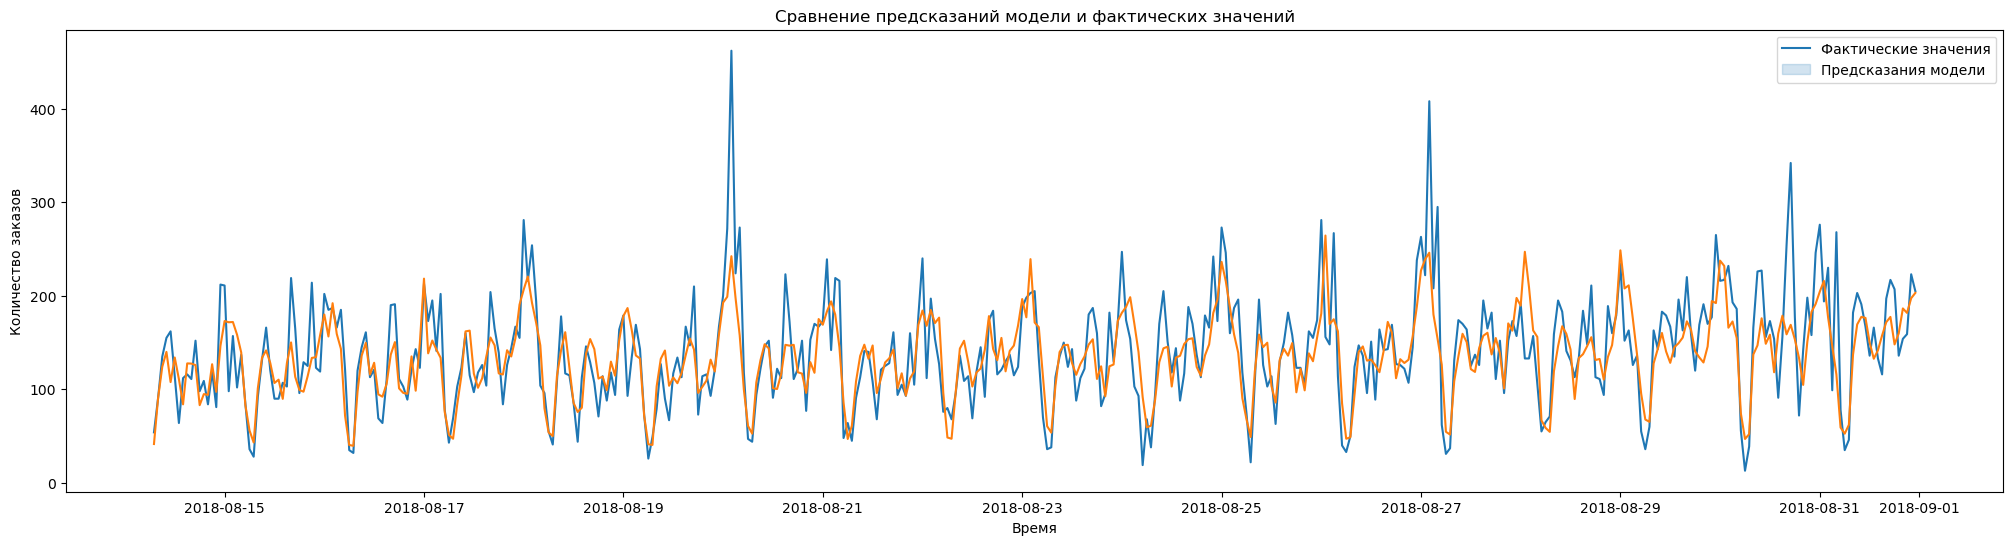

In [76]:
# Посотрим результаты предсказаний на графике
plt.figure(figsize = (25, 6))
sns.lineplot(y=y_test, x = y_test.index)
sns.lineplot(y=pred_xgbr_test, x = y_test.index)\
.set(title='Сравнение предсказаний модели и фактических значений',
     xlabel='Время',
     ylabel='Количество заказов');
plt.legend(['Фактические значения', 'Предсказания модели'])
plt.show()

## Вывод

Наша цель была построить модель для прогнозирования количество заказов такси на следующий час, чтобы компания могла привлекать больше водителей в период пиковой нагрузки.

Для нас были предоставлены данные о количествах заказах такси в аэропортах с '2018-03-01 00:00:00' по '2018-08-31 23:50:00'. Мы ресемплировали данные по одному часу.

Провели анализи временного ряда: скользящее среднее с размером окна 1 неделя показало, что кол-во заказов растёт каждый месяц, затем линия тренда это подтвердила. По  лини сезонности за день, также видна закономерность: с 12 часов ночи до 6 утра кол-во заказов падает, затем в общем можно сказать что кол-во заказоав увеличивается целый день до 00:00, но наблюдаются снижения в определенный переиод вермени(перед обедом и примерно с 15:00 до 18:00). С 18 часов до 00 заказы растут и достигают максимума.

Затем мы добавили несколько признаков:  час, день недели, выбрали 168 лагов со скользящим средним размером 168, разделили на тренировочную и тесотвую выборку в соотношении 10 к 1.

Обучили несколько моделей: LinearRegression, XGBRegressor, CatBoostRegressor, LGBMRegressor. По итогам результатов метрик RMSE на кросс-валидации выбрали XGBRegressor:

In [179]:
itog = pd.concat([result_models[['XGBRegressor']], pd.DataFrame({'XGBRegressor': [rmse_xgbr_test]}, index = ['RMSE(тест)'])])
itog

,XGBRegressor
Время обучения,1.624522
Время предсказания,0.040804
RMSE,23.023163
RMSE(тест),38.347352


Самое обидное, что простая эвристика "предсказыаем данными за прошлую неделю" дает RMSE около 39 "безо всякого вашего машинного обучения". Поэтому есть смысл сделать эту оценку и использовать данные за прошлую неделю в построении модели.